**Connection To Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

**Install MTCNN Module**

In [3]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 3.5MB/s 


In [4]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [6]:
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

import os
print(os.listdir("/content/gdrive/My Drive/A2SR-Updated"))

['Custom_Dataset', 'models']


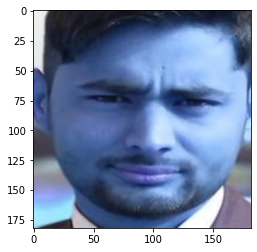

(182, 182, 3)


In [8]:
img = cv2.imread('/content/gdrive/My Drive/A2SR-Updated/Custom_Dataset/train_aligned-1/Adnan/adnan (10).jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()
print(img.shape)

In [10]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    face_img = cv2.imread(filename)
    image = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    # convert to array
    face = np.asarray(image)
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        try:
          face = extract_face(path)
          faces.append(face)
        except:
          pass
    return faces

cls_names = list()

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
        cls_names.extend(subdir)
    return np.asarray(X), np.asarray(y)
    

# load train dataset
trainX, trainy = load_dataset('/content/gdrive/My Drive/A2SR-Updated/Custom_Dataset/train_aligned-1/')
print(trainX.shape, trainy.shape)

# load test dataset
testX, testy = load_dataset('/content/gdrive/My Drive/A2SR-Updated/Custom_Dataset/test_aligned-1/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('custom-dataset.npz', trainX, trainy, testX, testy)


loaded 3 sample for class: Umair
loaded 7 sample for class: Sheikh_Burhan
loaded 20 sample for class: Shan
loaded 4 sample for class: Salman
loaded 11 sample for class: Taha
loaded 19 sample for class: Waseem
loaded 2 sample for class: Zubair
loaded 19 sample for class: Zeeshan
loaded 31 sample for class: Sikandar
loaded 7 sample for class: Usama
loaded 8 sample for class: Nabeel_Ahmad
loaded 19 sample for class: Mohsin
loaded 17 sample for class: Hamza_Shoukat
loaded 2 sample for class: Muhammad_Atif
loaded 4 sample for class: Saad
loaded 11 sample for class: Jamshaid
loaded 22 sample for class: Mubashir
loaded 47 sample for class: Rizwan
loaded 7 sample for class: Hamza_Zafar
loaded 3 sample for class: Muzzamil
loaded 20 sample for class: Adeel
loaded 10 sample for class: Ameer_Hamza
loaded 28 sample for class: Hamza
loaded 10 sample for class: Ans
loaded 40 sample for class: Adnan
loaded 17 sample for class: Ahmad
loaded 15 sample for class: Arish
(403, 160, 160, 3) (403,)
loaded 4 

In [11]:
# load the face dataset
data = np.load('custom-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (403, 160, 160, 3) (403,) (72, 160, 160, 3) (72,)


In [12]:
# load the facenet model
facenet_model = load_model('/content/gdrive/My Drive/FaceNet_Trainning_Project/model/facenet_keras.h5')
print('Loaded Model')

Loaded Model


In [13]:
print(facenet_model.inputs)
print(facenet_model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


Extract Features of all face images in Dataset

In [14]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()

for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('custom-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

(403, 128)
(72, 128)


**Create Classifier using SVM**

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=403, test=72
Accuracy: train=100.000, test=100.000


In [16]:
class_names = ['Adeel', 'Adnan', 'Ahmad', 'Ameer Hamza', 'Ans', 'Arish', 'Hamza', 'Hamza Shoukat', 'Hamza Zafar',
 'Jamshaid', 'Mohsin', 'Mubashir', 'Muhammad Atif', 'Muzzamil', 'Nabeel Ahmad', 'Rizwan', 'Saad', 'Salman',
 'Shan', 'Sheikh Burhan', 'Sikandar', 'Taha', 'Umair', 'Usama', 'Waseem', 'Zeeshan', 'Zubair']

**Generating Clasification Report on Test Dataset**

In [17]:
from sklearn.metrics import classification_report

print(classification_report(testy_enc, yhat_test, target_names=class_names))

               precision    recall  f1-score   support

        Adeel       1.00      1.00      1.00         7
        Adnan       1.00      1.00      1.00        11
        Ahmad       1.00      1.00      1.00         1
  Ameer Hamza       1.00      1.00      1.00         1
          Ans       1.00      1.00      1.00         1
        Arish       1.00      1.00      1.00         1
        Hamza       1.00      1.00      1.00         4
Hamza Shoukat       1.00      1.00      1.00         2
  Hamza Zafar       1.00      1.00      1.00         1
     Jamshaid       1.00      1.00      1.00         1
       Mohsin       1.00      1.00      1.00         1
     Mubashir       1.00      1.00      1.00         3
Muhammad Atif       1.00      1.00      1.00         1
     Muzzamil       1.00      1.00      1.00         1
 Nabeel Ahmad       1.00      1.00      1.00         3
       Rizwan       1.00      1.00      1.00        10
         Saad       1.00      1.00      1.00         1
       Sa

**Generating Confusion Matrix**

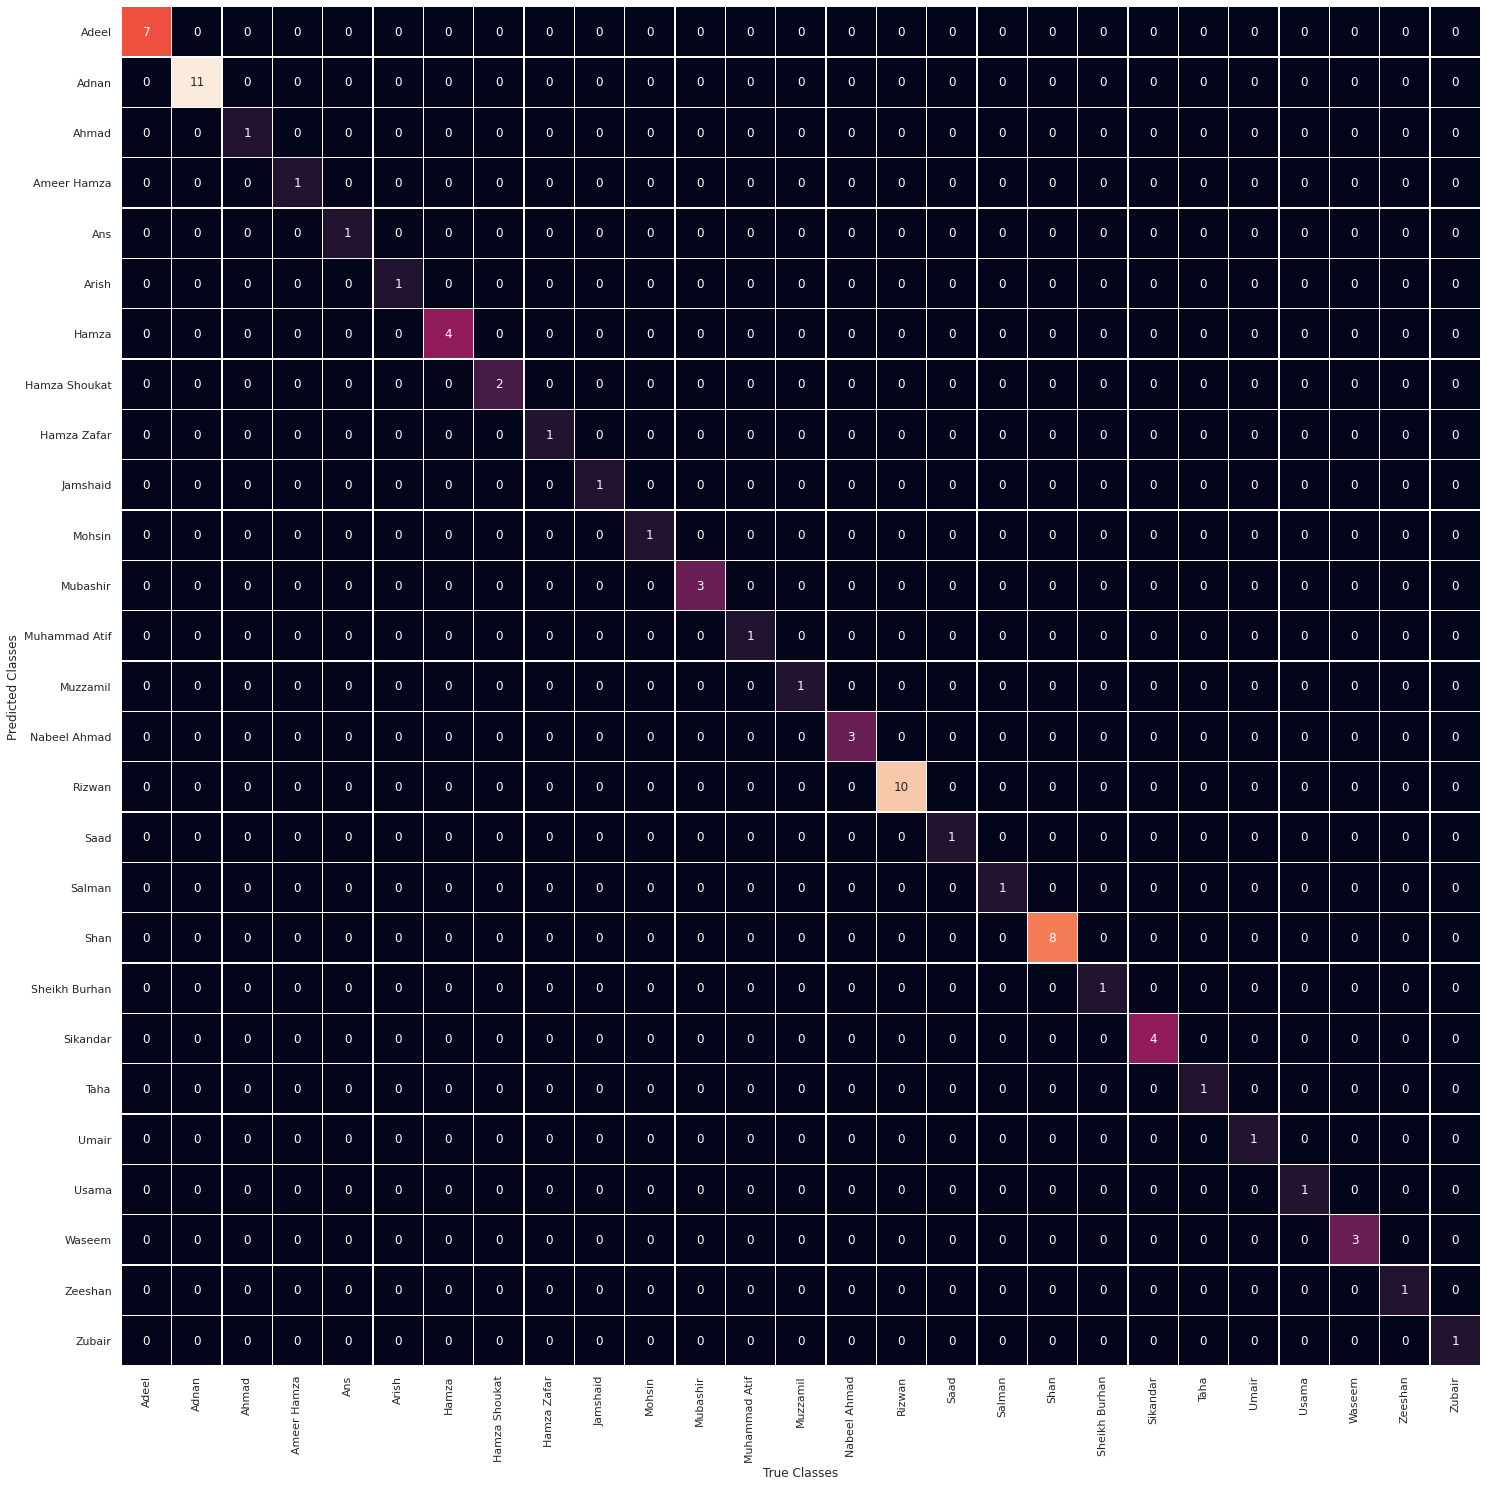

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(25,25))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

mat = confusion_matrix(testy_enc, yhat_test)
sns.heatmap(mat.T, square=True, annot=True, linewidths=.5, ax=ax, fmt='d', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('True Classes')
plt.ylabel('Predicted Classes');

In [19]:
#finding accuracy from the confusion matrix.
a = mat.shape
corrPred = 0
falsePred = 0

for row in range(a[0]):
    for c in range(a[1]):
        if row == c:
            corrPred +=mat[row,c]
        else:
            falsePred += mat[row,c]
print('Correct predictions: ', corrPred)
print('False predictions', falsePred)
print ('\n\nAccuracy of the Clasification is: ', (corrPred/(mat.sum()) * 100))

Correct predictions:  72
False predictions 0


Accuracy of the Clasification is:  100.0


**Evakuate Performance through random test face predictions**

Predicted: 
[ 1.53660517  6.79408005  1.7364472   3.20269115  1.48582267  1.32145518
  2.4684679   2.75684785  1.24498085  1.70187948  2.46170158  2.1204544
  1.18348559  1.40453132  0.63388649  1.43262059  2.05377542  1.55714376
 51.39542487  1.7390652   0.90357642  2.06521846  0.78670956  1.75368256
  1.1659318   1.60031812  1.49319635]
Expected: Shan


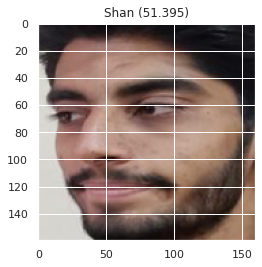

In [23]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])

random_face = testX[selection]

random_face_emd = emdTestX_norm[selection]

random_face_class = testy_enc[selection]

random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)

yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s' % (yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

In [ ]:
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score,cross_val_predict,train_test_split

predicted = cross_val_predict(model, emdTrainX_norm, trainy, cv=2)
print("accuracy",metrics.accuracy_score(trainy, predicted))
print("f1 score macro",metrics.f1_score(trainy, predicted, average='macro'))
print("f1 score micro",metrics.f1_score(trainy, predicted, average='micro'))
print("precision score",metrics.precision_score(trainy, predicted, average='macro'))
print("recall score",metrics.recall_score(trainy, predicted, average='macro')) 
print("hamming_loss",metrics.hamming_loss(trainy, predicted))
print("jaccard_similarity_score", metrics.jaccard_similarity_score(trainy, predicted))
# print("log_loss", metrics.log_loss(labels, predicted))
print("zero_one_loss", metrics.zero_one_loss(trainy, predicted))
print("matthews_corrcoef", metrics.matthews_corrcoef(trainy, predicted))
print("classification_report", metrics.classification_report(trainy, predicted))

In [ ]:
test_predicted = cross_val_predict(model, emdTestX_norm, testy, cv=4)
print("accuracy",metrics.accuracy_score(testy, test_predicted))
print("f1 score macro",metrics.f1_score(testy, test_predicted, average='macro'))
print("f1 score micro",metrics.f1_score(testy, test_predicted, average='micro'))
print("precision score",metrics.precision_score(testy, test_predicted, average='macro'))
print("recall score",metrics.recall_score(testy, test_predicted, average='macro')) 
print("hamming_loss",metrics.hamming_loss(testy, test_predicted))
print("jaccard_similarity_score", metrics.jaccard_similarity_score(testy, test_predicted))
# print("log_loss", metrics.log_loss(labels, predicted))
print("zero_one_loss", metrics.zero_one_loss(testy, test_predicted))
print("matthews_corrcoef", metrics.matthews_corrcoef(testy, test_predicted))
print("classification_report", metrics.classification_report(testy, test_predicted))